### 定义可能用到的一系列模型和参数   vit_model

In [1]:
"""
original code from rwightman:
https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
"""
from functools import partial
from collections import OrderedDict

import torch
import torch.nn as nn


def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    # in_c:输入通道数，3，通常为RGB。
    # 我在想这里的img_size和patch_size直接以元组的形式传入是否会更方便。
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size) # 将图片大小和patch大小都转换为元组，方便后面的计算
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1]) # 计算patch网格大小
        self.num_patches = self.grid_size[0] * self.grid_size[1]  # patchs的数量

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        '''
        为何这里的卷积不需要padding呢？
        因为stride=kernel_size，每个像素块在一次卷积中都只参与一次。
        而padding适用于中间部分像素块由重复参与卷积的情况。
        '''
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        # 要求输入的图片大小必须和初始化时设置的img_size一致
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x


class Attention(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_c (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_ratio (float): dropout rate
            attn_drop_ratio (float): attention dropout rate
            drop_path_ratio (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
        """
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ("fc", nn.Linear(embed_dim, representation_size)),
                ("act", nn.Tanh())
            ]))
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        # Weight init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)  # [B, 196, 768]
        # [1, 1, 768] -> [B, 1, 768]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)  # [B, 197, 768]
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(m):
    """
    ViT weight initialization
    :param m: module
    """
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)




def vit_base_patch16_224(num_classes: int = 1000):
    """
    ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1zqb08naP0RPqqfSXfkB2EA  密码: eu9f
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=None,
                              num_classes=num_classes)
    return model


def vit_base_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=768 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_base_patch32_224(num_classes: int = 1000):
    """
    ViT-Base model (ViT-B/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1hCv0U8pQomwAtHBYc4hmZg  密码: s5hl
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=None,
                              num_classes=num_classes)
    return model


def vit_base_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch32_224_in21k-8db57226.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=768 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_large_patch16_224(num_classes: int = 1000):
    """
    ViT-Large model (ViT-L/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-1k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    链接: https://pan.baidu.com/s/1cxBgZJJ6qUWPSBNcE4TdRQ  密码: qqt8
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=None,
                              num_classes=num_classes)
    return model


def vit_large_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch16_224_in21k-606da67d.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=1024 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_large_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch32_224_in21k-9046d2e7.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=1024 if has_logits else None,
                              num_classes=num_classes)
    return model

### 定义一系列工具函数   utils

In [2]:
import os
import sys
import json
import pickle
import random

import torch
from tqdm import tqdm

import matplotlib.pyplot as plt


def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)  # 保证随机结果可复现
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root)

    # 遍历文件夹，一个文件夹对应一个类别
    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    # 排序，保证各平台顺序一致
    flower_class.sort()
    # 生成类别名称以及对应的数字索引
    class_indices = dict((k, v) for v, k in enumerate(flower_class))
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    train_images_path = []  # 存储训练集的所有图片路径
    train_images_label = []  # 存储训练集图片对应索引信息
    val_images_path = []  # 存储验证集的所有图片路径
    val_images_label = []  # 存储验证集图片对应索引信息
    every_class_num = []  # 存储每个类别的样本总数
    supported = [".jpg", ".JPG", ".png", ".PNG"]  # 支持的文件后缀类型
    # 遍历每个文件夹下的文件
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        # 遍历获取supported支持的所有文件路径
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        # 排序，保证各平台顺序一致
        images.sort()
        # 获取该类别对应的索引
        image_class = class_indices[cla]
        # 记录该类别的样本数量
        every_class_num.append(len(images))
        # 按比例随机采样验证样本
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  # 如果该路径在采样的验证集样本中则存入验证集
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  # 否则存入训练集
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num)))
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))
    assert len(train_images_path) > 0, "number of training images must greater than 0."
    assert len(val_images_path) > 0, "number of validation images must greater than 0."

    plot_image = False
    if plot_image:
        # 绘制每种类别个数柱状图
        plt.bar(range(len(flower_class)), every_class_num, align='center')
        # 将横坐标0,1,2,3,4替换为相应的类别名称
        plt.xticks(range(len(flower_class)), flower_class)
        # 在柱状图上添加数值标签
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # 设置x坐标
        plt.xlabel('image class')
        # 设置y坐标
        plt.ylabel('number of images')
        # 设置柱状图的标题
        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label


def plot_data_loader_image(data_loader):
    batch_size = data_loader.batch_size
    plot_num = min(batch_size, 4)

    json_path = './class_indices.json'
    assert os.path.exists(json_path), json_path + " does not exist."
    json_file = open(json_path, 'r')
    class_indices = json.load(json_file)

    for data in data_loader:
        images, labels = data
        for i in range(plot_num):
            # [C, H, W] -> [H, W, C]
            img = images[i].numpy().transpose(1, 2, 0)
            # 反Normalize操作
            img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
            label = labels[i].item()
            plt.subplot(1, plot_num, i+1)
            plt.xlabel(class_indices[str(label)])
            plt.xticks([])  # 去掉x轴的刻度
            plt.yticks([])  # 去掉y轴的刻度
            plt.imshow(img.astype('uint8'))
        plt.show()


def write_pickle(list_info: list, file_name: str):
    with open(file_name, 'wb') as f:
        pickle.dump(list_info, f)


def read_pickle(file_name: str) -> list:
    with open(file_name, 'rb') as f:
        info_list = pickle.load(f)
        return info_list


def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    accu_loss = torch.zeros(1).to(device)  # 累计损失
    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    optimizer.zero_grad()

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        loss.backward()
        accu_loss += loss.detach()

        data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num


@torch.no_grad()
def evaluate(model, data_loader, device, epoch):
    loss_function = torch.nn.CrossEntropyLoss()

    model.eval()

    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    accu_loss = torch.zeros(1).to(device)  # 累计损失

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        accu_loss += loss

        data_loader.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num

### 定义加载数据集的相关函数

In [3]:
from PIL import Image
import torch
from torch.utils.data import Dataset


class MyDataSet(Dataset):
    """自定义数据集"""

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])
        # RGB为彩色图片，L为灰度图片
        if img.mode != 'RGB':
            raise ValueError("image: {} isn't RGB mode.".format(self.images_path[item]))
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    @staticmethod
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

### 训练  train

In [4]:
import os
import math
import argparse

import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms


# from my_dataset import MyDataSet
# from vit_model import vit_base_patch16_224_in21k as create_model
# from utils import read_split_data, train_one_epoch, evaluate


def main(args):
    device = torch.device(args.device if torch.cuda.is_available() else "cpu")

    if os.path.exists("./weights") is False:
        os.makedirs("./weights")

    tb_writer = SummaryWriter()

    train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(args.data_path)

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

    # 实例化训练数据集
    train_dataset = MyDataSet(images_path=train_images_path,
                              images_class=train_images_label,
                              transform=data_transform["train"])

    # 实例化验证数据集
    val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

    batch_size = args.batch_size
    #nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    nw=0
    print('Using {} dataloader workers every process'.format(nw))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=nw,
                                               collate_fn=train_dataset.collate_fn)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=nw,
                                             collate_fn=val_dataset.collate_fn)

    # model = create_model(num_classes=args.num_classes, has_logits=False).to(device)
    model = vit_large_patch32_224_in21k(num_classes=args.num_classes, has_logits=False).to(device)

    if args.weights != "":
        assert os.path.exists(args.weights), "weights file: '{}' not exist.".format(args.weights)
        weights_dict = torch.load(args.weights, map_location=device)
         #删除不需要的权重
        del_keys = ['head.weight', 'head.bias'] if model.has_logits \
            else ['pre_logits.fc.weight', 'pre_logits.fc.bias', 'head.weight', 'head.bias']
        for k in del_keys:
            del weights_dict[k]
        print(model.load_state_dict(weights_dict, strict=False))

    if args.freeze_layers:
        for name, para in model.named_parameters():
            # 除head, pre_logits外，其他权重全部冻结
            if "head" not in name and "pre_logits" not in name:
                para.requires_grad_(False)
            else:
                print("training {}".format(name))

    pg = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(pg, lr=args.lr, momentum=0.9, weight_decay=5E-5)
    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    lf = lambda x: ((1 + math.cos(x * math.pi / args.epochs)) / 2) * (1 - args.lrf) + args.lrf  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

    for epoch in range(args.epochs):
        # train
        train_loss, train_acc = train_one_epoch(model=model,
                                                optimizer=optimizer,
                                                data_loader=train_loader,
                                                device=device,
                                                epoch=epoch)

        scheduler.step()

        # validate
        val_loss, val_acc = evaluate(model=model,
                                     data_loader=val_loader,
                                     device=device,
                                     epoch=epoch)

        tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
        tb_writer.add_scalar(tags[0], train_loss, epoch)
        tb_writer.add_scalar(tags[1], train_acc, epoch)
        tb_writer.add_scalar(tags[2], val_loss, epoch)
        tb_writer.add_scalar(tags[3], val_acc, epoch)
        tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

        torch.save(model.state_dict(), "./weights/model_large32_in21k-{}.pth".format(epoch))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_classes', type=int, default=5)
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=8)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--lrf', type=float, default=0.01)
    # parser.add_argument('5', type=int, default=5)
    # parser.add_argument('10', type=int, default=10)
    # parser.add_argument('8', type=int, default=8)
    # parser.add_argument('0.001', type=float, default=0.001)
    # parser.add_argument('0.01', type=float, default=0.01)

    # 数据集所在根目录
    # https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
    # parser.add_argument('--data-path', type=str,
    #                     default="/data/flower_photos")
    parser.add_argument('--data-path', type=str,
                        default="./data_set/flower_data/flower_photos")
    parser.add_argument('--model-name', default='model1', help='create model name')

    # 预训练权重路径，如果不想载入就设置为空字符
    # parser.add_argument('--weights', type=str, default='./vit_base_patch16_224_in21k.pth',
    #                     help='initial weights path')
    parser.add_argument('--weights', type=str, default="./data_set/weight/vit_large_patch32_224_in21k.pth",
                        help='initial weights path')
    # 是否冻结权重
    parser.add_argument('--freeze-layers', type=bool, default=True)
    parser.add_argument('--device', default='cuda:0', help='device id (i.e. 0 or 0,1 or cpu)')
    
    parser.add_argument('-f', type=str, default="读取额外的参数")
   #opt = parser.parse_args()
    opt = parser.parse_args(args=[
         '--num_classes','5',
         '--epochs','10',
         '--batch-size','8',
         '--lr','0.001',
         '--lrf','0.01',
         '--data-path',"./data_set/flower_data/flower_photos",
         '--model-name','model1',
         '--weights','./data_set/weight/vit_large_patch32_224_in21k.pth',
         '--freeze-layers','True',
         '--device','cuda:0'
     ])
    main(opt)

3670 images were found in the dataset.
2939 images for training.
731 images for validation.
Using 0 dataloader workers every process


C:\Users\eyrine\AppData\Local\Temp\ipykernel_25032\1595979467.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load(args.weights, map_location=devic

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])
training head.weight
training head.bias
[valid epoch 9] loss: 0.212, acc: 0.973: 100%|██████████| 92/92 [00:12<00:00,  7.15it/s]


### 预测并显示结果  predict

C:\Users\eyrine\AppData\Local\Temp\ipykernel_25032\1633201170.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_path, map_lo

class: daisy        prob: 0.191
class: dandelion    prob: 0.146
class: roses        prob: 0.0607
class: sunflowers   prob: 0.566
class: tulips       prob: 0.036


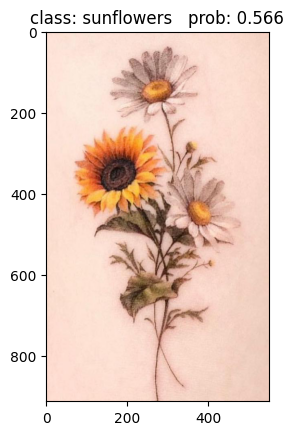

In [7]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
#from torchvision import models
import matplotlib.pyplot as plt

# from vit_model import vit_base_patch16_224_in21k as create_model

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # load image
    # img_path = "../tulip.jpg"
    img_path = "./daisy3.png"
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    # [N, C, H, W]
    img = data_transform(img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    json_path = './class_indices.json'
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    with open(json_path, "r") as f:
        class_indict = json.load(f)

    # create model
    model =vit_large_patch32_224_in21k(num_classes=5, has_logits=False).to(device)

    # load model weights
    model_weight_path = "./weights/model_large32_in21k-9.pth"
    #model_weight_path = './vit_base_patch16_224_in21k.pth'
    model.load_state_dict(torch.load(model_weight_path, map_location=device))
    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.show()


if __name__ == '__main__':
    main()